In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nibabel as nib
import sklearn.model_selection
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import random
from torchvision import transforms
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load brain imaging data using NiBabel
brain_data = nib.load("/content/drive/MyDrive/recipe/depressionClassifier/avg152T1_LR_nifti.hdr")
X = brain_data.get_fdata()
data_shape = X.shape
data_shape

(91, 109, 91)

In [ ]:
X

memmap([[[10.,  9., 10., ...,  1.,  1.,  0.],
         [ 9.,  9.,  9., ...,  1.,  1.,  1.],
         [ 9., 10., 10., ...,  1.,  1.,  1.],
         ...,
         [10.,  9.,  9., ...,  5.,  5.,  6.],
         [10.,  9.,  9., ...,  6.,  6.,  6.],
         [ 9.,  9.,  9., ...,  6.,  6.,  5.]],

        [[11., 11., 10., ...,  1.,  1.,  1.],
         [11., 11., 11., ...,  1.,  1.,  1.],
         [11., 11., 10., ...,  2.,  1.,  1.],
         ...,
         [11., 11., 10., ...,  6.,  6.,  6.],
         [11., 12., 11., ...,  6.,  6.,  6.],
         [11., 10., 11., ...,  6.,  6.,  6.]],

        [[11., 11., 12., ...,  1.,  1.,  1.],
         [12., 11., 12., ...,  1.,  1.,  1.],
         [12., 13., 12., ...,  2.,  2.,  1.],
         ...,
         [12., 12., 12., ...,  7.,  6.,  6.],
         [12., 12., 11., ...,  6.,  6.,  6.],
         [12., 12., 12., ...,  7.,  6.,  5.]],

        ...,

        [[11., 10., 10., ...,  1.,  1.,  0.],
         [11., 10., 10., ...,  1.,  1.,  1.],
         [10., 10.

In [ ]:
# Load labels depression diagnosis
data = pd.read_csv('/content/drive/MyDrive/recipe/depressionClassifier/updated_oasis_cross-sectional0.csv')
# Remove rows with missing values
data = data.dropna(subset=['MMSE'])
y = data['depression_diagnosis'].replace({'not depressed': 0, 'likely depressed': 1}).values
np.save('oasis_cross-sectional.npy', y)
y = np.load('oasis_cross-sectional.npy', allow_pickle=True)
num_subjects = X.shape[0]
y = y[:num_subjects]

In [ ]:
mmse = data['MMSE'].values
print("Shape of mmse:", mmse.shape)
print("Shape of y:", y.shape)
print("Value of num_subjects:", num_subjects)


Shape of mmse: (235,)
Shape of y: (91,)
Value of num_subjects: 91


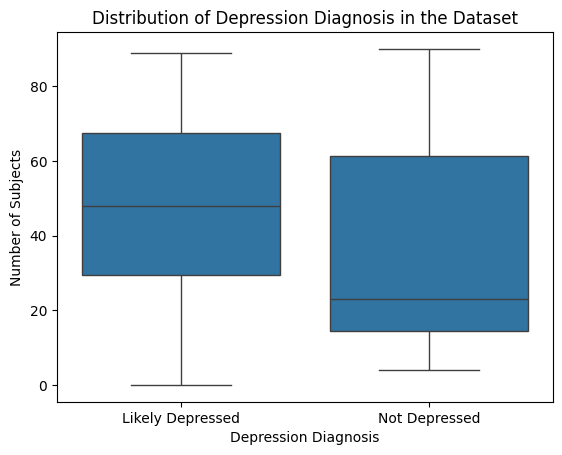

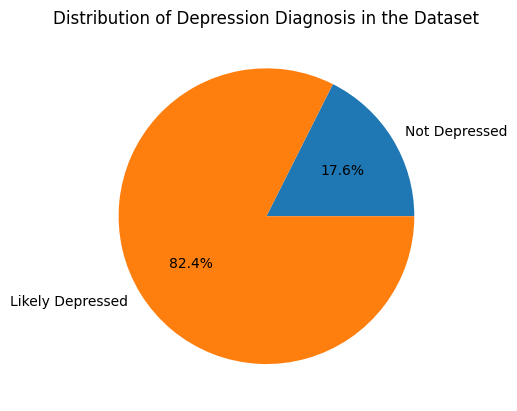

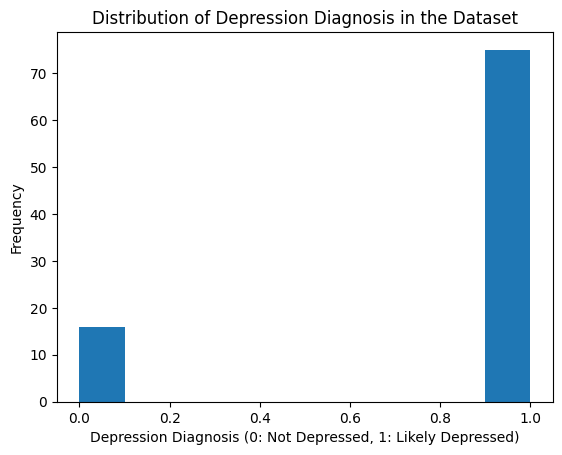

In [ ]:

# Create a DataFrame for the data
data = pd.DataFrame(y, columns=['Depression Diagnosis'])

data['Depression Diagnosis'] = data['Depression Diagnosis'].replace({0: 'Not Depressed', 1: 'Likely Depressed'})

sns.boxplot(x='Depression Diagnosis', y=data.index, data=data)
plt.xlabel('Depression Diagnosis')
plt.ylabel('Number of Subjects')
plt.title('Distribution of Depression Diagnosis in the Dataset')
plt.show()


plt.pie(np.bincount(y), labels=['Not Depressed', 'Likely Depressed'], autopct="%1.1f%%")
plt.title('Distribution of Depression Diagnosis in the Dataset')
plt.show()


plt.hist(y)
plt.xlabel('Depression Diagnosis (0: Not Depressed, 1: Likely Depressed)')
plt.ylabel('Frequency')
plt.title('Distribution of Depression Diagnosis in the Dataset')
plt.show()



In [ ]:
# Preprocess the data
X = X.reshape(num_subjects, *data_shape[1:])
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()
X = X / X.max()
X = X.reshape(num_subjects, -1)
X = X[:, :1000]
feature_dim = 1000

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)


In [ ]:
#DNN having 3layers with relu activation
class DNN(nn.Module):
    def __init__(self, feature_dim, hidden_dim, output_dim):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(feature_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.softmax(self.fc3(x))
        x = self.dropout(x)
        return x

In [ ]:

hidden_dim = 64
output_dim = 1
learning_rate = 0.00001
batch_size = 1
epochs = 100

In [ ]:
# Model, optimizer, and loss function
model = DNN(feature_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [ ]:
#train model
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model = None
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        optimizer.zero_grad()
        print(X_batch)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (y_pred.argmax(dim=1) == y_batch).sum().item()
        if (i + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item():.4f}, Accuracy: {(y_pred.argmax(dim=1) == y_batch).sum().item() / batch_size:.4f}')
    train_loss /= len(X_train)
    train_acc /= len(X_train)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    model.eval()
    val_loss = 0
    val_acc = 0
    for i in range(0, len(X_val), batch_size):
        X_batch = X_val[i:i+batch_size]
        y_batch = y_val[i:i+batch_size]
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        val_loss += loss.item()
        val_acc += (y_pred.argmax(dim=1) == y_batch).sum().item()
    val_loss /= len(X_val)
    val_acc /= len(X_val)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model


Streaming output truncated to the last 5000 lines.
         0.0784, 0.0824, 0.0784, 0.0745, 0.0784, 0.0745, 0.0745, 0.0745, 0.0745,
         0.0745, 0.0745, 0.0745, 0.0784, 0.0745, 0.0784, 0.0824, 0.0824, 0.0863,
         0.0863, 0.0941, 0.0941, 0.0980, 0.0980, 0.1059, 0.1059, 0.1059, 0.1098,
         0.1098, 0.1098, 0.1098, 0.1098, 0.1059, 0.1059, 0.1059, 0.0980, 0.0902,
         0.0824, 0.0784, 0.0706, 0.0667, 0.0588, 0.0549, 0.0510, 0.0510, 0.0431,
         0.0431, 0.0392, 0.0392, 0.0353, 0.0353, 0.0314, 0.0314, 0.0314, 0.0314,
         0.0275, 0.0275, 0.0275, 0.0235, 0.0235, 0.0196, 0.0196, 0.0196, 0.0196,
         0.0196, 0.0196, 0.0196, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157,
         0.0118, 0.0118, 0.0118, 0.0118, 0.0118, 0.0118, 0.0118, 0.0118, 0.0118,
         0.0118, 0.0118, 0.0118, 0.0118, 0.0118, 0.0941, 0.0902, 0.0941, 0.0902,
         0.0941, 0.0902, 0.0902, 0.0902, 0.0863, 0.0824, 0.0863, 0.0824, 0.0824,
         0.0863, 0.0824, 0.0824, 0.0863, 0.0863, 0.0902, 0

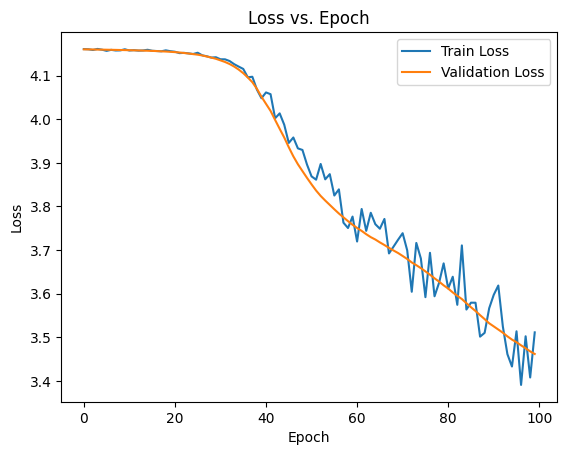

In [ ]:
# Plot the train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

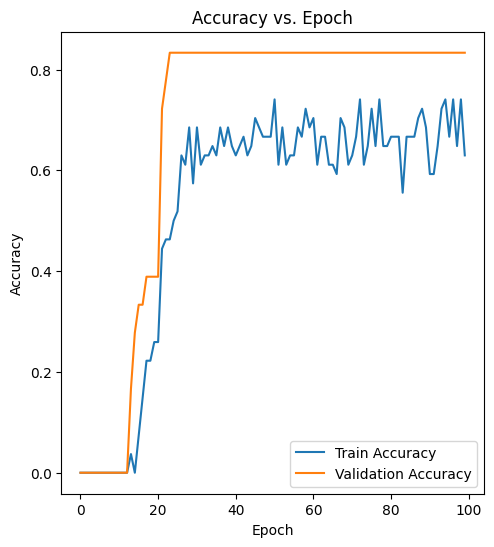

In [ ]:
# Plot the train and validation accuracies
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

In [ ]:
# Evaluation on the test set
best_model.eval()
test_loss = 0
test_acc = 0
for i in range(0, len(X_test), batch_size):
    X_batch = X_test[i:i+batch_size]
    y_batch = y_test[i:i+batch_size]
    y_pred = best_model(X_batch)
    loss = criterion(y_pred, y_batch)
    test_loss += loss.item()
    test_acc += (y_pred.argmax(dim=1) == y_batch).sum().item()
test_loss /= len(X_test)
test_acc /= len(X_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.1760, Test Accuracy: 0.8421
